In [1]:
##-----------------------------------------------------
## Summary : classify hand written digits using logits
## Author  : Venkata Srinivas Vemprala
## SourceCode : https://github.com/Hvass-Labs/TensorFlow-Tutorials
##-----------------------------------------------------

%matplotlib inline      
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [2]:
## Importing the handwritten data from tensorflow
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/',one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
## Lets print the size of the various datasets
print('Sizes of datasets : ')
print('Training DataSet : ', len(data.train.labels))
print('Testing DataSet : ', len(data.test.labels))
print('Validation DataSet : ',len(data.validation.labels))

Sizes of datasets : 
Training DataSet :  55000
Testing DataSet :  10000
Validation DataSet :  5000


In [4]:
## Declaring constants
img_size = 28
img_shape = (img_size,img_size)
img_size_flat = img_size * img_size
num_classes = 10
batch_size = 100

trueLabelsTrain = np.array([label.argmax() for label in data.train.labels])
trueLabelsTest = np.array([label.argmax() for label in data.test.labels])
trueLabelsValidation = np.array([label.argmax() for label in data.validation.labels])

In [5]:
## Lets write a function to display images using Matplotlib

def plotImages(images,trueLabels,predLabels=None):
    assert len(images) == len(trueLabels) == 9
    
    #Create a 3x3 subPlot image
    (fig,axes) = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i,ax in enumerate(axes.flat):
        # Plot Image
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        
        if predLabels==None:
            xlabel = "True : "+str(trueLabels[i])
        else:
            xlabel = "True : "+str(trueLabels[i])+" Pred : "+str(predLabels[i])
        
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

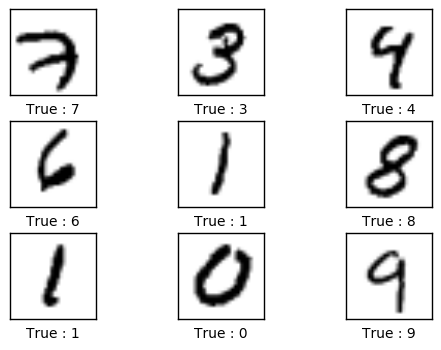

In [6]:
## lets plot few images
images = data.train.images[0:9]
trueLabels = np.array([label.argmax() for label in data.train.labels[0:9]])

plotImages(images,trueLabels)

In [7]:
## Lets write a function to print the confusion Matrix

def print_conf_mat(trueLabels,predLabels):
    cm = confusion_matrix(y_true=trueLabels,y_pred=predLabels)
    print(cm)
    
## Lets write a function to print sample errors
def print_example_errors(images,trueLabels,predLabels):
    correct = np.equal(trueLabels,predLabels)
    indexes = np.where(correct==False)
    
    incorrectImages = images[indexes]
    incorrectTrueLabels = trueLabels[indexes]
    incorrectPredLabels = predLabels[indexes]
    
    plotImages(incorrectImages[0:9],incorrectTrueLabels[0:9],incorrectPredLabels[0:9])

In [8]:
## Lets write a function to plot weights
def plotWeights(weights):
    ##find max and min of weights
    w_min = np.min(weights)
    w_max = np.max(weights)
    
    fig,axes = plt.subplots(3,4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ## plot only for first 10 weights
        if(i<10):
            img = weights[:,i].reshape(img_shape)
            ax.set_xlabel('Weights : '+str(i))
            ax.imshow(img,vmin=w_min, vmax=w_max, cmap='seismic')
            
        ##remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
        


In [9]:
## Lets start creating a tensorflow graph

## Input placeholders
x = tf.placeholder(tf.float32, shape=[None,img_size_flat])
y_true = tf.placeholder(tf.float32, shape=[None,num_classes])

## Variables
w = tf.Variable(tf.zeros([img_size_flat,num_classes]))
b = tf.Variable(tf.zeros([num_classes]))

## Model declaration
y = tf.matmul(x,w) + b
y_pred = tf.nn.softmax(y)
y_pred_class = tf.argmax(y_pred,dimension=1)

## CostFunction declaration
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,labels=y_true))
correct = tf.equal(tf.argmax(y_true,dimension=1),tf.argmax(y_pred,dimension=1))
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

## Optimizer declaration
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)


In [10]:
## Lets start running the graph 
session = tf.Session()
session.run(tf.global_variables_initializer())


def runOptimization(numIter): 
    for j in range(numIter) : 
        session.run(tf.global_variables_initializer())
    
        batchSize = 100
        numIterations = int(len(data.train.labels)/batchSize)
    
        for i in range(numIterations):
            [x_batch,y_batch] = data.train.next_batch(batchSize)
        
            feed = {x:x_batch,y_true:y_batch}
            session.run(optimizer,feed_dict=feed)
        
        labelsTrain = session.run(y_pred,feed_dict={x:data.train.images,y_true:data.train.labels})
        labelsTest = session.run(y_pred,feed_dict={x:data.test.images,y_true:data.test.labels})
        weights = session.run(w,feed_dict={x:data.test.images,y_true:data.test.labels})
        
        accuracyTrain = session.run(accuracy,feed_dict={x:data.train.images,y_true:data.train.labels})
        accuracyTest = session.run(accuracy,feed_dict={x:data.test.images,y_true:data.test.labels})
        
        if(j==numIter-1):
            print('Iteration ',str(j),' : ')
            print('Training accuracy : ',accuracyTrain*100)
            print('Testing accuracy : ',accuracyTest*100)
            
        return labelsTrain,labelsTest,weights

In [11]:
labelsTrain,labelsTest,weights = runOptimization(1)

print_conf_mat(np.argmax(data.train.labels,axis=1),np.argmax(labelsTrain,axis=1))

Iteration  0  : 
Training accuracy :  89.9254560471
Testing accuracy :  90.4100000858
[[5311    1    7   13   11   36   24    2   25   14]
 [   1 6039   22   21    6   27    5    8   36   14]
 [  66  125 4662  153  110   35   83   68  119   49]
 [  35   46   93 4939    7  293   23   35   58  109]
 [  15   36   20    3 4831    3   41    6   25  327]
 [  85   58   15  130   60 4407   59   13   83   77]
 [  65   29   31    4   48  134 5086    1   11    8]
 [  28   74   72   31   68   10    3 4995   18  416]
 [  51  212   50  267   49  357   38    8 4165  192]
 [  49   35   14   77  119   35    2   84   15 5024]]


/home/srvv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


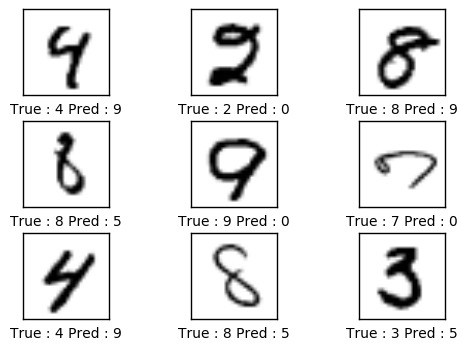

In [12]:
## lets print example errors
print_example_errors(data.train.images,np.argmax(data.train.labels,axis=1),np.argmax(labelsTrain,axis=1))

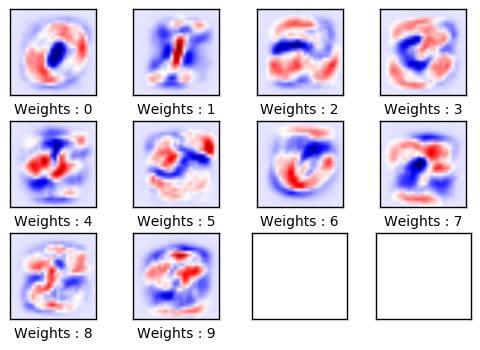

In [13]:
plotWeights(weights)